In [1]:
import torch 

import metal.mmtl.dataset as dataset
import numpy as np
import pandas as pd

from metal.mmtl.bert_tasks import create_tasks
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.scorer import Scorer
from metal.utils import convert_labels
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


### Load Model and Data

In [2]:
#model_path = '/dfs/scratch0/jdunnmon/mmtl/sota_quest/debugging/COLA/COLA_19_48_08/best_model.pth'
model_path = '/dfs/scratch0/jdunnmon/mmtl/sota_quest/debugging/RTE/RTE_16_35_57/best_model.pth'
csv_path = "/".join(model_path.split('/')[0:-2]) #set to -1 if permissions exist
task_name = model_path.split('/')[-3]

bert_model = 'bert-base-uncased'
max_len = 256
bert_output_dim = 768
dl_kwargs = {"batch_size": 32, 'shuffle': False}

In [3]:
#Get DataLoader
dataset_cls = getattr(dataset, task_name.upper() + "Dataset")
dev_ds = dataset_cls(
    split="dev",
    bert_model=bert_model,
    max_len=max_len,
    max_datapoints=-1,
)
dev_dl = dev_ds.get_dataloader(**dl_kwargs)

#Load best model for specified task
tasks = create_tasks(
        task_names=[task_name],
        bert_model=bert_model,
        split_prop=0.8,
        max_len=max_len,
        dl_kwargs={"batch_size": 1},
        bert_output_dim=bert_output_dim,
        max_datapoints=10,
    )

model = MetalModel(tasks, verbose=False, device=-1)
model.load_state_dict(torch.load(model_path)['model'])

Loading BERT model...



Loading RTE Dataset
Loading BERT model...



Loading BERT model...


### Generate DataFrame of Predictions and True Labels

In [4]:
data = {
    'sentence1': [],
    'sentence2': [],
    'label': [],
    'score' : []
}
max_batches = 100
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=True)
from tqdm import tqdm
count = 0
for x, y in tqdm(list(dev_dl)):
    for tokens_idx in x[0]:
        tokens = tokenizer.convert_ids_to_tokens(tokens_idx.numpy())
        phrases = ' '.join(tokens).replace('[PAD]', '').replace('[CLS]', '').split('[SEP]')
        data['sentence1'] += [phrases[0]]
        if len(phrases) > 1:
            data['sentence2'] += [phrases[1]] 
        else:
            data['sentence2'] += ['NA']
    scores = model.calculate_output(x, [task_name])[task_name].detach().cpu().numpy()[:, 0] # .flatten()
    data['score'] += list(scores)
    data['label'] += list(convert_labels(y, 'categorical', 'onezero').numpy())
    count += 1
    if count > max_batches:
        break
        

df_error = pd.DataFrame(data, columns=['sentence1', 'sentence2', 'score', 'label'])
df_error['pred'] = 1* (df_error.score > 0.5)
df_error['is_wrong'] = df_error['pred'] != df_error['label']

100%|██████████| 9/9 [00:01<00:00,  4.97it/s]


### Saving and Loading Error DataFrame

In [5]:
def save_dataframe(df,filepath):
    df.to_csv(filepath, sep='\t')
    print('Saved dataframe to: ', filepath)
    
def load_dataframe(filepath):
    df = pd.read_csv(filepath, sep='\t')
    return df

filepath = f'{csv_path}/dev_error_analysis.tsv'
save_dataframe(df_error,filepath)
df_error = load_dataframe(filepath)
df_error.head()

Saved dataframe to:  /dfs/scratch0/jdunnmon/mmtl/sota_quest/debugging/RTE/dev_error_analysis.tsv


,Unnamed: 0,sentence1,sentence2,score,label,pred,is_wrong
0,0,"dana reeve , the widow of the actor christoph...",christopher reeve had an accident .,0.461119,0,0,False
1,1,"yet , we now are discovering that antibiotics...",bacteria is winning the war against antibioti...,0.310028,1,0,True
2,2,cairo is now home to some 15 million people -...,15 million tonnes of rubbish are produced dai...,0.759440,0,1,True
3,3,"the ami ##sh community in pennsylvania , whic...",pennsylvania has the biggest ami ##sh communi...,0.316320,0,0,False
4,4,security forces were on high alert after an e...,security forces were on high alert after a ca...,0.832552,1,1,False


### Looking at Random Examples

In [6]:
def print_random_pred(df):
    row = df.iloc[np.random.randint(df.shape[0])]
    print(f'sentence1: \t{row.sentence1}')
    print(f'sentence2: \t{row.sentence2}')
    print('score: \t{:.4f}'.format(row.score))    
    print(f'label: \t{row.label}')   

In [7]:
print("\033[1mINCORRECT PREDICTIONS\033[0;0m")
for i in range(3):
    print_random_pred(df_error[df_error.is_wrong==True])
    print()
    
print("\033[1mCORRECT PREDICTIONS\033[0;0m")
for i in range(3):
    print_random_pred(df_error[df_error.is_wrong==False])
    print()

INCORRECT PREDICTIONS
sentence1: 	 wilson has , after all , produced all three offspring albums , including " smash , " the one that has astonished everybody by selling 1 million copies in four months , establishing the here ##to ##for ##e unknown group as the leader , with green day , of an unprecedented wave of commercial success for punk . 
sentence2: 	 " smash " is the title of the third album of the offspring . 
score: 	0.7452
label: 	0

sentence1: 	 released in 1995 , tyson returned to boxing , winning the world boxing council title in 1996 . the same year , however , he lost to evan ##der holy ##field , and in a 1997 rematch bit holy ##field ' s ear , for which he was temporarily banned from boxing . 
sentence2: 	 in 1996 mike tyson bit holy ##field ' s ear . 
score: 	0.7653
label: 	0

sentence1: 	 the massachusetts supreme judicial court has cleared the way for lesbian and gay couples in the state to marry , ruling that government attorneys " failed to identify any constitution

## Sandbox for Error Analysis

**1. We want to look at examples that are "barely" wrong and "barely" right since we have hope for boosts here.**

In [8]:
def print_barely_wrong_pred(df,thresh=0.05):
    df_temp = df[df.is_wrong==True]
    idx = np.where(np.abs(df_temp.score - 0.5) <= thresh)[0]
    row = df_temp.iloc[np.random.choice(list(idx))]
    
    print(f'sentence1: \t{row.sentence1}')
    print(f'sentence2: \t{row.sentence2}')
    print('score: \t{:.4f}'.format(row.score))    
    print(f'label: \t{row.label}')  
    
def print_barely_right_pred(df,thresh=0.05):
    df_temp = df[df.is_wrong==False]
    idx = np.where(np.abs(df_temp.score - 0.5) <= thresh)[0]
    row = df_temp.iloc[np.random.choice(list(idx))]
    
    print(f'sentence1: \t{row.sentence1}')
    print(f'sentence2: \t{row.sentence2}')
    print('score: \t{:.4f}'.format(row.score))    
    print(f'label: \t{row.label}')   

In [9]:
print("\033[1mBARELY WRONG\033[0;0m")
for i in range(3):
    print_barely_wrong_pred(df_error)
    print()
    
print("\033[1mBARELY RIGHT\033[0;0m")
for i in range(3):
    print_barely_right_pred(df_error)
    print()

BARELY WRONG
sentence1: 	 confident that those grading papers would understand answers written in text - speak , ha ##que stressed that in some exams , including english , text abbreviation ##s would be penal ##ized . 
sentence2: 	 ha ##que wants to include english in some exams . 
score: 	0.5478
label: 	0

sentence1: 	 napkin ##s , invitations and plain old paper cost more than they did a month ago . 
sentence2: 	 the cost of paper is rising . 
score: 	0.4550
label: 	1

sentence1: 	 capital punishment acts as a deter ##rent . 
sentence2: 	 capital punishment is a deter ##rent to crime . 
score: 	0.4875
label: 	1

BARELY RIGHT
sentence1: 	 the memo , written by marc allen connell ##y ( who was general counsel to the funeral services commission at the time ) and sent to dick mc ##neil ( the bush - appointed chairman of the funeral commission ) , stated that connell ##y " received information " from texas state officials that two of the funeral commissioners worked for sci . 
sentence2: 

**2. We also want to look at examples we got completely wrong since that could point to a systematic bias in the data/model. It could also help us find examples in the dataset that are mislabeled by human annotators**

In [10]:
def print_very_wrong_pred(df,thresh=0.95):
    df_temp = df[df.is_wrong==True]
    try:
        idx = np.where(np.abs(df_temp.score - df_temp.label) >= thresh)[0]
        row = df_temp.iloc[np.random.choice(list(idx))]
    except:
        print("Threshold too high, reducing by 0.05")
        idx = np.where(np.abs(df_temp.score - df_temp.label) >= thresh-0.05)[0]
        row = df_temp.iloc[np.random.choice(list(idx))]
    
    print(f'sentence1: \t{row.sentence1}')
    print(f'sentence2: \t{row.sentence2}')
    print('score: \t{:.4f}'.format(row.score))    
    print(f'label: \t{row.label}') 

In [11]:
print("\033[1mVERY WRONG\033[0;0m")
for i in range(3):
    print_very_wrong_pred(df_error)
    print()

VERY WRONG
Threshold too high, reducing by 0.05
sentence1: 	 ar ##lene blu ##m is a legendary trail ##bla ##zer by any measure . def ##ying the climbing establishment of the 1970s , she led the first teams of women on successful ascent ##s of mt . mckinley and anna ##pur ##na , and was the first american woman to attempt mt . everest . in her long , adventurous career , she has played a leading role in more than twenty expeditions and forged a place for women in the per ##ilo ##us arena of high - altitude mountain ##eering . 
sentence2: 	 a woman succeeds in climbing everest solo . 
score: 	0.9125
label: 	0

Threshold too high, reducing by 0.05
sentence1: 	 ah ##ern , who was travelling to tokyo for an eu - japan summit yesterday , will consult with other eu leaders by telephone later this week in an effort to find an agreed candidate . 
sentence2: 	 a summit between europe and japan is taking place in the japan ##ise capital . 
score: 	0.0663
label: 	1

Threshold too high, reducing by

**3. To find systematic errors, we can also look for correlations between certain features and the incorrectness a la Socratic**


We can make this way more sophisticated by perhaps using embeddings instead of this simple [BoW featurization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [12]:
#Create a vector of correct/incorrect predictions
y = 2*(np.array(df_error.is_wrong.astype(float))-0.5)

#Create corpus by combining sentences
combined = []
for a,b in zip(np.array(df_error.sentence1),np.array(df_error.sentence2)):
    combined.append(str(a)+str(b))

In [13]:
#Create BoW featurization
from sklearn.feature_extraction.text import CountVectorizer
corpus = np.array(list(df_error.sentence1))
vectorizer = CountVectorizer(ngram_range=(2,5), stop_words='english')
X = vectorizer.fit_transform(corpus)

#Run LR to find correlations
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty="l1")
lr_model.fit(X, y)

/dfs/scratch0/vschen/venv-mmtl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

10 000
holy field
harry potter
capital punishment
old city


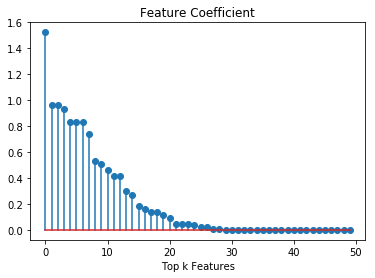

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.stem(np.sort(np.abs(lr_model.coef_)[0])[::-1][0:50])
plt.title('Feature Coefficient')
plt.xlabel('Top k Features')

top_idx = np.argsort(np.abs(lr_model.coef_)[0])[::-1][0:50]
names = vectorizer.get_feature_names()
for i in range(5):
    print (names[top_idx[i]])

In [15]:
print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
for i in range(5):
    idx = list(np.where(X.todense()[:,top_idx[i]] == 1)[0])
    for ii in range(len(idx)):
        df_temp = df_error
        row = df_temp.iloc[idx[ii]]

        print(f'sentence1: \t{row.sentence1}')
        print(f'sentence2: \t{row.sentence2}')
        print('score: \t{:.4f}'.format(row.score))    
        print(f'label: \t{row.label}')
        print()

SYSTEMATIC EXAMPLES
sentence1: 	 cairo is now home to some 15 million people - a bu ##rgeon ##ing population that produces approximately 10 , 000 tonnes of rubbish per day , putting an enormous strain on public services . in the past 10 years , the government has tried hard to encourage private investment in the refuse sector , but some estimate 4 , 000 tonnes of waste is left behind every day , fest ##ering in the heat as it waits for someone to clear it up . it is often the people in the poor ##est neighbourhoods that are worst affected . but in some areas they are fighting back . in shu ##bra , one of the northern districts of the city , the residents have taken to the streets armed with dust ##pan ##s and brushes to clean up public areas which have been used as public dump ##s . 
sentence2: 	 15 million tonnes of rubbish are produced daily in cairo . 
score: 	0.7594
label: 	0

sentence1: 	 the town is also home to the dalai lama and to more than 10 , 000 tibetan ##s living in exile